<a href="https://colab.research.google.com/github/Frsagco/ML_denoising/blob/main/ML_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progetto Machine Learning

In [134]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow_datasets as tfds
import cv2
from tensorflow.keras import Sequential, Model, Input, utils
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Concatenate

from tensorflow.keras.optimizers import Adam

from keras.initializers import RandomNormal
from scipy.stats import norm, bernoulli, poisson
from skimage.util import random_noise
from google.colab.patches import cv2_imshow
import scipy.stats as stats


## Import dataset BSD

In [135]:
import pathlib
dataset_url = "https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='BSDS300',
                                   untar=True)

data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('images/*/*.jpg')))
image_count_train = len(list(data_dir.glob('images/train/*.jpg')))
image_count_test = len(list(data_dir.glob('images/test/*.jpg')))


print(image_count)

test_temp = list(data_dir.glob('images/test/*'))
train_temp = list(data_dir.glob('images/train/*'))

300


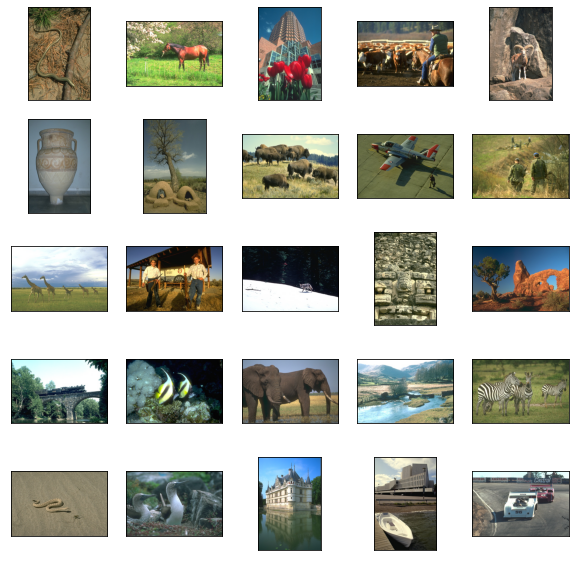

In [136]:
#codice per mostrare alcuni esempi
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(PIL.Image.open(str(test_temp[i])), cmap=plt.cm.binary)
   
plt.show()

Codice per salvare le immagini in due array


*   Array di matrici RGB 
*   Array di oggetti immagine

Eseguiamo il crop delle immagini

In [137]:
n=256

test_as_img = []
test_as_arr = []
for i in range(image_count_test):
  image=cv2.imread(str(test_temp[i]))
  image=image[0:n,0:n,0:3]
  test_as_img.append(image)
  image=np.array(image, dtype = 'uint8')
  image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  test_as_arr.append(image)
  
train_as_img=[]
train_as_arr=[]
for i in range(image_count_train):
  image=cv2.imread(str(train_temp[i]))
  image=image[0:n,0:n,0:3]
  train_as_img.append(image)
  image=np.array(image, dtype = 'uint8')
  image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  train_as_arr.append(image)

image_size=[n,n,3]
print(image_size)


[256, 256, 3]


In [138]:
#plt.figure(figsize=(10,10))
#for i in range(25):
 #   plt.subplot(5,5,i+1)
 #   plt.xticks([])
 #   plt.yticks([])
 #   plt.grid(False)
  #  plt.imshow(test_as_arr[i], cmap=plt.cm.binary)
   
#plt.show()

## Adding Noise

In [139]:
def truncnorm_(lower, upper, sigma):
  mu = (lower+upper)/2

  X = np.random.normal(mu, sigma)

  if(X < lower):
    return lower
  if(X > upper):
    return upper

  return X

In [140]:
def apply_noise_to_image(img):
  noise_choises=["gaussian", "s&p", "speckle"];
  index=np.random.randint(0,3);

  if noise_choises[index]=="gaussian":
    mean=0;

    lower, upper = 0.005, 0.03
    sigma = 0.005
    var=truncnorm_(lower, upper, sigma)
    
    noise_img = random_noise(img, mode='gaussian', mean=mean, var=var)

  elif noise_choises[index]=="s&p":
    lower, upper = 0.02, 0.07
    sigma = 0.01

    amount=truncnorm_(lower, upper, sigma)
    noise_img = random_noise(img, mode='s&p', amount=amount)

  elif noise_choises[index]=="speckle":
    lower, upper = 0.005, 0.02
    sigma = 0.003

    var=truncnorm_(lower, upper, sigma)
    noise_img = random_noise(img, mode='speckle', var=var)

  else:
    print('PANIC: Wrong noise index.')
    return
  noise_img = np.array(255*noise_img, dtype = 'uint8')
  noise_img_rgb = cv2.cvtColor(noise_img, cv2.COLOR_BGR2RGB)
  return noise_img_rgb #random_noise returns [0,1] or [-1,1] value

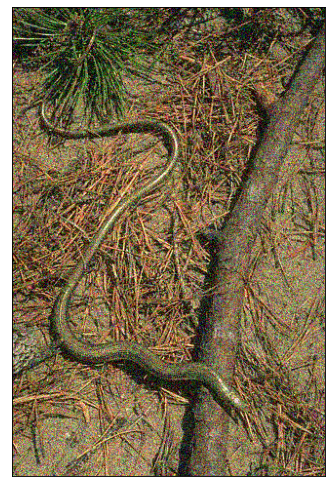

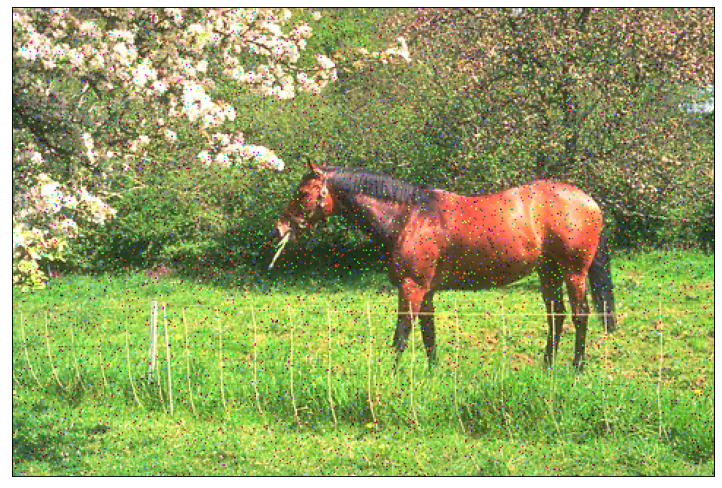

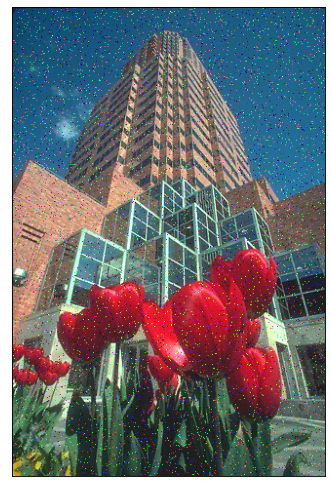

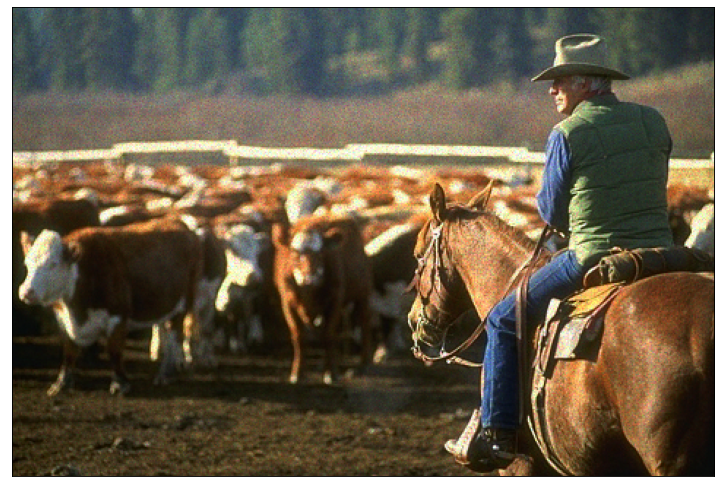

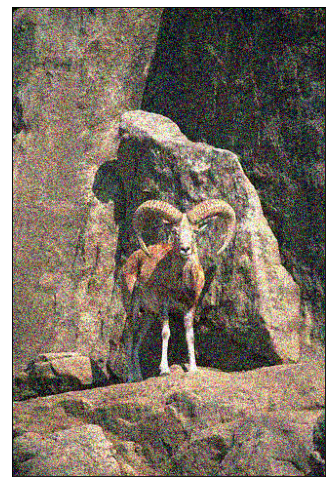

In [141]:
from matplotlib import pyplot as plt

for i in range(5):
    plt.figure(figsize=(50,45), dpi=80)

    img = cv2.imread(str(test_temp[i]))
    noise_img=apply_noise_to_image(img)

    plt.subplot(5,1,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((noise_img), cmap=plt.cm.binary)
   
plt.show()

## Generatore - Discriminatore 

In [142]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

In [143]:
image_shape=image_size
print(image_size)

[256, 256, 3]


In [144]:
from numpy.core.fromnumeric import resize
def define_generator(image_shape):
  # weight initialization

  init = RandomNormal(stddev=0.02)

  # image input
  in_image = Input(shape=image_shape)
  # encoder model
  e1 = define_encoder_block(in_image, 64, batchnorm=False)
  e2 = define_encoder_block(e1, 128)
  e3 = define_encoder_block(e2, 256)
  e4 = define_encoder_block(e3, 512)
  e5 = define_encoder_block(e4, 512)
  e6 = define_encoder_block(e5, 512)
  #e7 = define_encoder_block(e6, 512)
  # bottleneck, no batch norm and relu
  b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e6)
  b = Activation('relu')(b)
  # decoder model
  # d1 = decoder_block(b, e7, 512)
  # d2 = decoder_block(d1, e6, 512)
  # d3 = decoder_block(d2, e5, 512)
  # d4 = decoder_block(d3, e4, 512, dropout=False)
  # d5 = decoder_block(d4, e3, 256, dropout=False)
  # d6 = decoder_block(d5, e2, 128, dropout=False)
  # d7 = decoder_block(d6, e1, 64, dropout=False)
  d1 = decoder_block(b, e6, 512)
  d2 = decoder_block(d1, e5, 512)
  d3 = decoder_block(d2, e4, 512)
  d4 = decoder_block(d3, e3, 256, dropout=False)
  d5 = decoder_block(d4, e2, 128, dropout=False)
  d6 = decoder_block(d5, e1, 64, dropout=False)


  # output
  g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d6)

  out_image = Activation('tanh')(g)
  # define model
  model = Model(in_image, out_image, name='Generator')
  
  return model

In [145]:
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image= Input(shape=image_shape)
	# target image input
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	# d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	# d = BatchNormalization()(d)
	# d = LeakyReLU(alpha=0.2)(d)

	# patch output
	d = Flatten()(d)
	d = Dense(1024, activation=None)(d)
	d = LeakyReLU(alpha=0.2)(d)
	output_discriminator = Dense(1, activation='sigmoid')(d)

	# define model
	model = Model(in_image, output_discriminator, name='Discriminator')
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5], metrics=["accuracy"])
	return model

In [146]:
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	#for layer in d_model.layers:
	#	if not isinstance(layer, BatchNormalization):
	#		layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	print(in_src.shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	############
	dis_out = d_model(gen_out)
	#dis_out = d_model(in_src)
	#############
	# src image as input, generated image and classification output
	model = Model(in_src, [gen_out, dis_out], name='GAN')
	#model = Model(in_src, dis_out, name='GAN')
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	#model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[1])
	model.compile(loss=['mse', 'binary_crossentropy'], optimizer=opt, loss_weights=[1,1e-3])
	return model


In [147]:
# define the models
d_model = define_discriminator(image_size)
g_model = define_generator(image_size)
# define the composite model
gan_model = define_gan(g_model, d_model, image_size)

(None, 256, 256, 3)


In [148]:
d_model.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_33 (Conv2D)          (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 128, 128, 64)      0         
                                                                 
 conv2d_34 (Conv2D)          (None, 64, 64, 128)       131200    
                                                                 
 batch_normalization_42 (Bat  (None, 64, 64, 128)      512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                     

In [149]:
g_model.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_37 (Conv2D)             (None, 128, 128, 64  3136        ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 leaky_re_lu_38 (LeakyReLU)     (None, 128, 128, 64  0           ['conv2d_37[0][0]']              
                                )                                                         

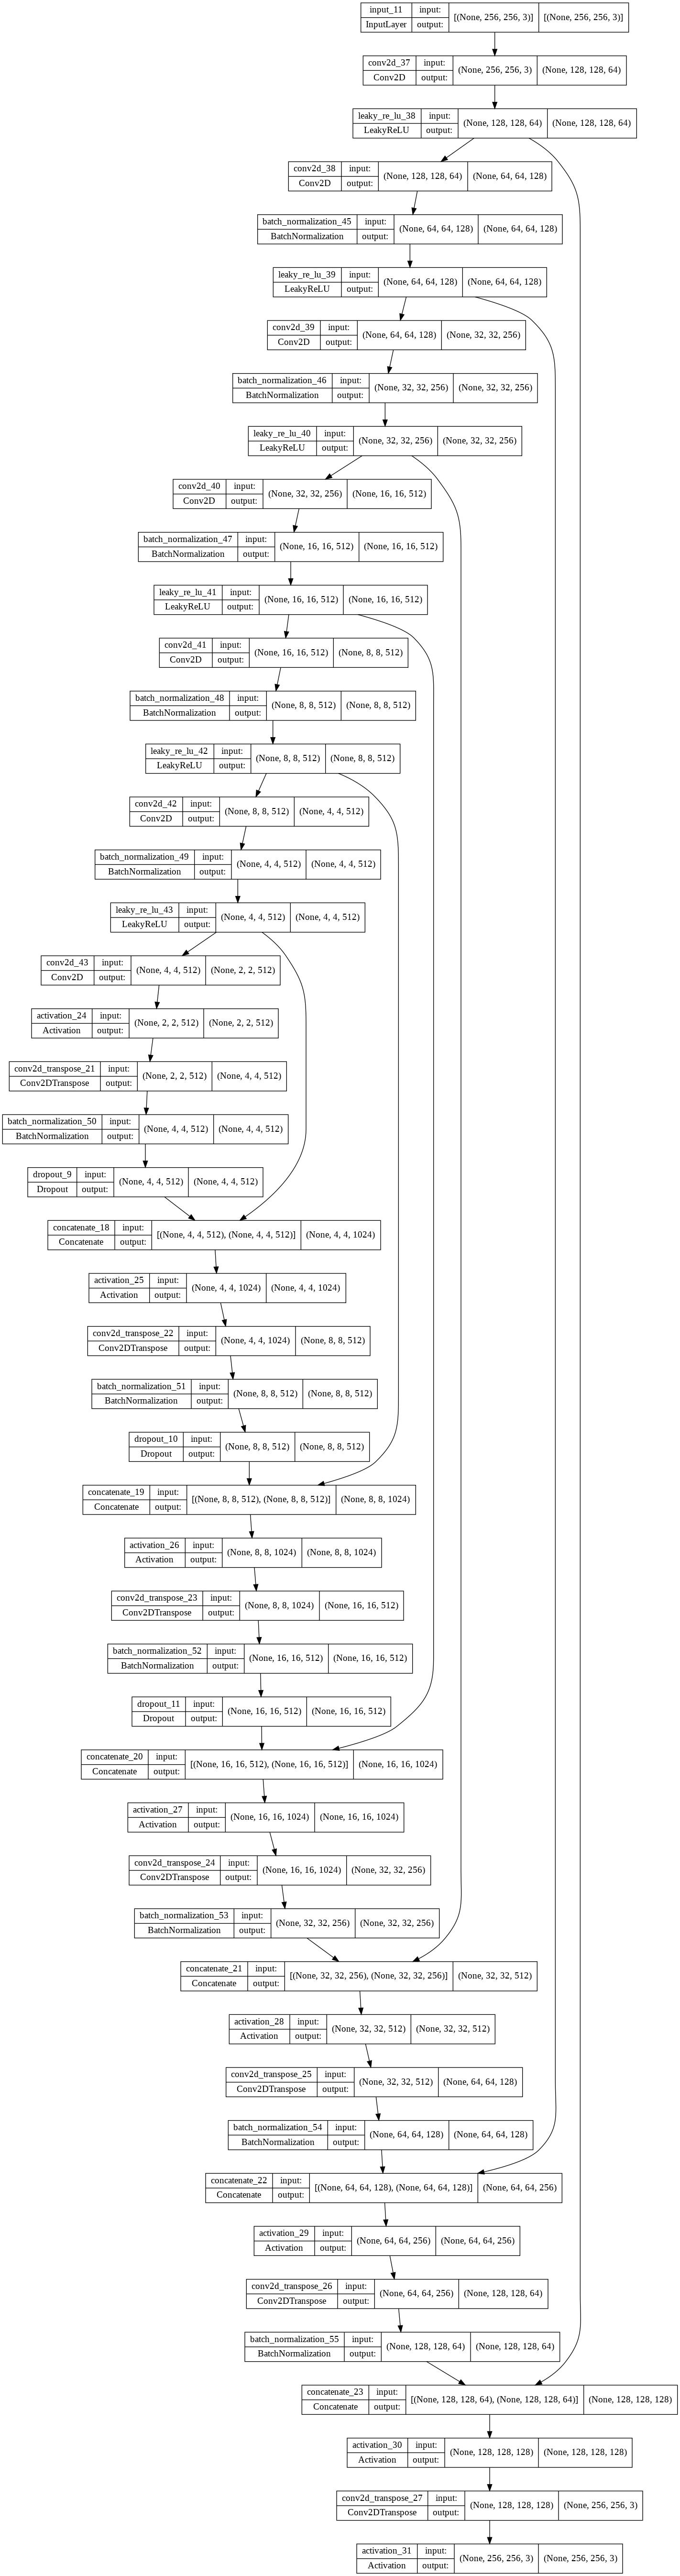

In [150]:
keras.utils.plot_model(g_model, "Generator.jpg", show_shapes=True)

In [151]:
gan_model.summary()

Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 Generator (Functional)      (None, 256, 256, 3)       41841283  
                                                                 
 Discriminator (Functional)  (None, 1)                 136979905 
                                                                 
Total params: 178,821,188
Trainable params: 178,811,588
Non-trainable params: 9,600
_________________________________________________________________


In [152]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [153]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples):
  # choose random instances
  ix = np.random.randint(0, image_count_train, n_samples)
  ix = np.array(ix).astype(int)
  X = np.zeros((n_samples, 256, 256, 3))
  # retrieve selected images
  for i in range(n_samples):
    X[i]=train_as_arr[ix[i]]
  X = np.reshape(X, (X.shape[0],X.shape[1],X.shape[2],X.shape[3]))
  # generate 'real' class labels (1)
  y = np.ones(n_samples)
  #y = np.ones((n_samples, patch_shape, 1))
  return X , y, ix
 
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, ix, n_samples, noisy_samples):
  # generate fake instance
  #samples = np.zeros((n_samples, 256, 256, 3))
  #for i in range(n_samples):
  #  samples[i]=apply_noise_to_image(train_as_img[ix[i]])

  noisy_samples = np.reshape(noisy_samples, (noisy_samples.shape[0], noisy_samples.shape[1], noisy_samples.shape[2], noisy_samples.shape[3]))
  #print("Samples:")
  #print(n_samples)
  #print(noisy_samples.shape)
  
  X = g_model.predict(noisy_samples)
  #print("FakeSamples:")
  #print(X.shape)
  # create 'fake' class labels (0)
  y = np.zeros(n_samples)
  return X , y

In [154]:
# utility function to plot some figures
def plot_figures(x, n, figsize=(50,45), dpi=80):
  plt.figure(figsize=figsize)
  for i in range(n):

    plt.subplot(1,n,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    img = ((x[i]*127.5) + 127.5).astype("uint8")

    # rescale for visualization purposes
    plt.imshow(img)

  plt.show()

In [155]:
# TODO: va nel for
		# summarize performance
#		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
#		if (i+1) % (bat_per_epo * 10) == 0:
#			summarize_performance(i, g_model, dataset)

In [156]:
def train_2(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
  # calculate the number of batches per training epoch
  bat_per_epo = int(image_count_train / n_batch)
  # calculate the number of training iterations
  n_steps = bat_per_epo * n_epochs
  # manually enumerate epochs
  for i in range(n_steps):
    # select a batch of real samples
    X_real, y_real, ix = generate_real_samples(dataset, n_batch)

    #Generate noisy images
    X_noisy = np.zeros((n_batch, 256, 256, 3))
    for i in range(n_batch):
      X_noisy[i]=apply_noise_to_image(train_as_img[ix[i]])
    X_noisy = np.reshape(X_noisy, (X_noisy.shape[0],X_noisy.shape[1],X_noisy.shape[2],X_noisy.shape[3]))
    
    # ####################
    # train discriminator
    d_model.trainable=True
    # generate a batch of fake samples
    X_gen, y_fake = generate_fake_samples(g_model, ix, n_batch, X_noisy)
    # update discriminator for original samples
    d_loss1 = d_model.train_on_batch(X_real, y_real)
    # update discriminator for noisy samples
    d_loss2 = d_model.train_on_batch(X_gen, y_fake)

    # #######################
    # train generator
    d_model.trainable=False;

    fake_labels = [1] * n_batch
    fake_labels = np.reshape(fake_labels, (-1,))
    g_loss, _, _ = gan_model.train_on_batch(X_noisy, [X_real, fake_labels])

In [157]:
def gen_benchmark_images(img, index):
  noise_choises=["gaussian", "s&p", "speckle"];

  if noise_choises[index]=="gaussian":
    mean=0;
    upper = 0.03
    lower=0.005
    noise_img = random_noise(img, mode='gaussian', mean=mean, var=lower)

  elif noise_choises[index]=="s&p":
    upper = 0.07
    lower=0.02
    noise_img = random_noise(img, mode='s&p', amount=lower)

  elif noise_choises[index]=="speckle":
    upper = 0.02
    lower=0.005
    noise_img = random_noise(img, mode='speckle', var=lower)

  else:
    print('PANIC: Wrong noise index.')
    return
  noise_img = np.array(255*noise_img, dtype = 'uint8')
  noise_img_rgb = cv2.cvtColor(noise_img, cv2.COLOR_BGR2RGB)
  return noise_img_rgb #random_noise returns [0,1] or [-1,1] value

In [158]:
def train_3(d_model, g_model, gan_model, dataset, n_epochs=100, batch_size=1):
  benchmarkImages=np.zeros((3, 256, 256, 3))
  benchmarkImages[0]=gen_benchmark_images(train_as_img[0], 0)
  benchmarkImages[1]=gen_benchmark_images(train_as_img[0], 1)
  benchmarkImages[2]=gen_benchmark_images(train_as_img[0], 2)
  benchmarkImages = np.reshape(benchmarkImages, (benchmarkImages.shape[0], benchmarkImages.shape[1], benchmarkImages.shape[2], benchmarkImages.shape[3]))
  plot_figures(benchmarkImages, 1)
  
  # calculate the number of batches per training epoch
  
  # calculate the number of training iterations
  # manually enumerate epochs
  for epoch in range(n_epochs):
    print("Epoch "+ str(epoch))
    batch_per_epoch = int(image_count_train / batch_size)
    # select a batch of real and fake samples 
    X_real, y_real, ix = generate_real_samples(dataset, batch_size)
    
    X_noisy = np.zeros((batch_size, 256, 256, 3))
    for j in range(batch_size):
      img=train_as_img[ix[j]]
      X_noisy[j]=apply_noise_to_image(img)
    X_noisy = np.reshape(X_noisy, (X_noisy.shape[0], X_noisy.shape[1],X_noisy.shape[2],X_noisy.shape[3]))

    for i in range(batch_per_epoch):
      #Generate noisy images
      #print("Batch "+ str(i))

      # ####################
      # train discriminator
      d_model.trainable=True
      # generate a batch of fake samples
      X_gen, y_fake = generate_fake_samples(g_model, ix, batch_size, X_noisy)
      # update discriminator for original samples
      d_loss1 = d_model.train_on_batch(X_real, y_real)
      # update discriminator for noisy samples
      d_loss2 = d_model.train_on_batch(X_gen, y_fake)

      # #######################
      # train generator
      d_model.trainable=False;

      fake_labels = [1] * batch_size
      fake_labels = np.reshape(fake_labels, (-1,))
      g_loss, _, _ = gan_model.train_on_batch(X_noisy, [X_real, fake_labels])
   
    #print("epoch " + str(epoch) + ": discriminator loss " + str(discLoss)+  " ( "  + str(discAcc) + " ) - generator loss" + str(ganLoss))

    # it is important to regularly visualize the output
    #images= np.zeros((3, 256, 256, 3))
    print(benchmarkImages.shape)
    images=g_model.predict(benchmarkImages)
    print(images.shape)
    #if (epoch % 5) == 0:
    plot_figures(images,1)
    

(256, 256, 3)


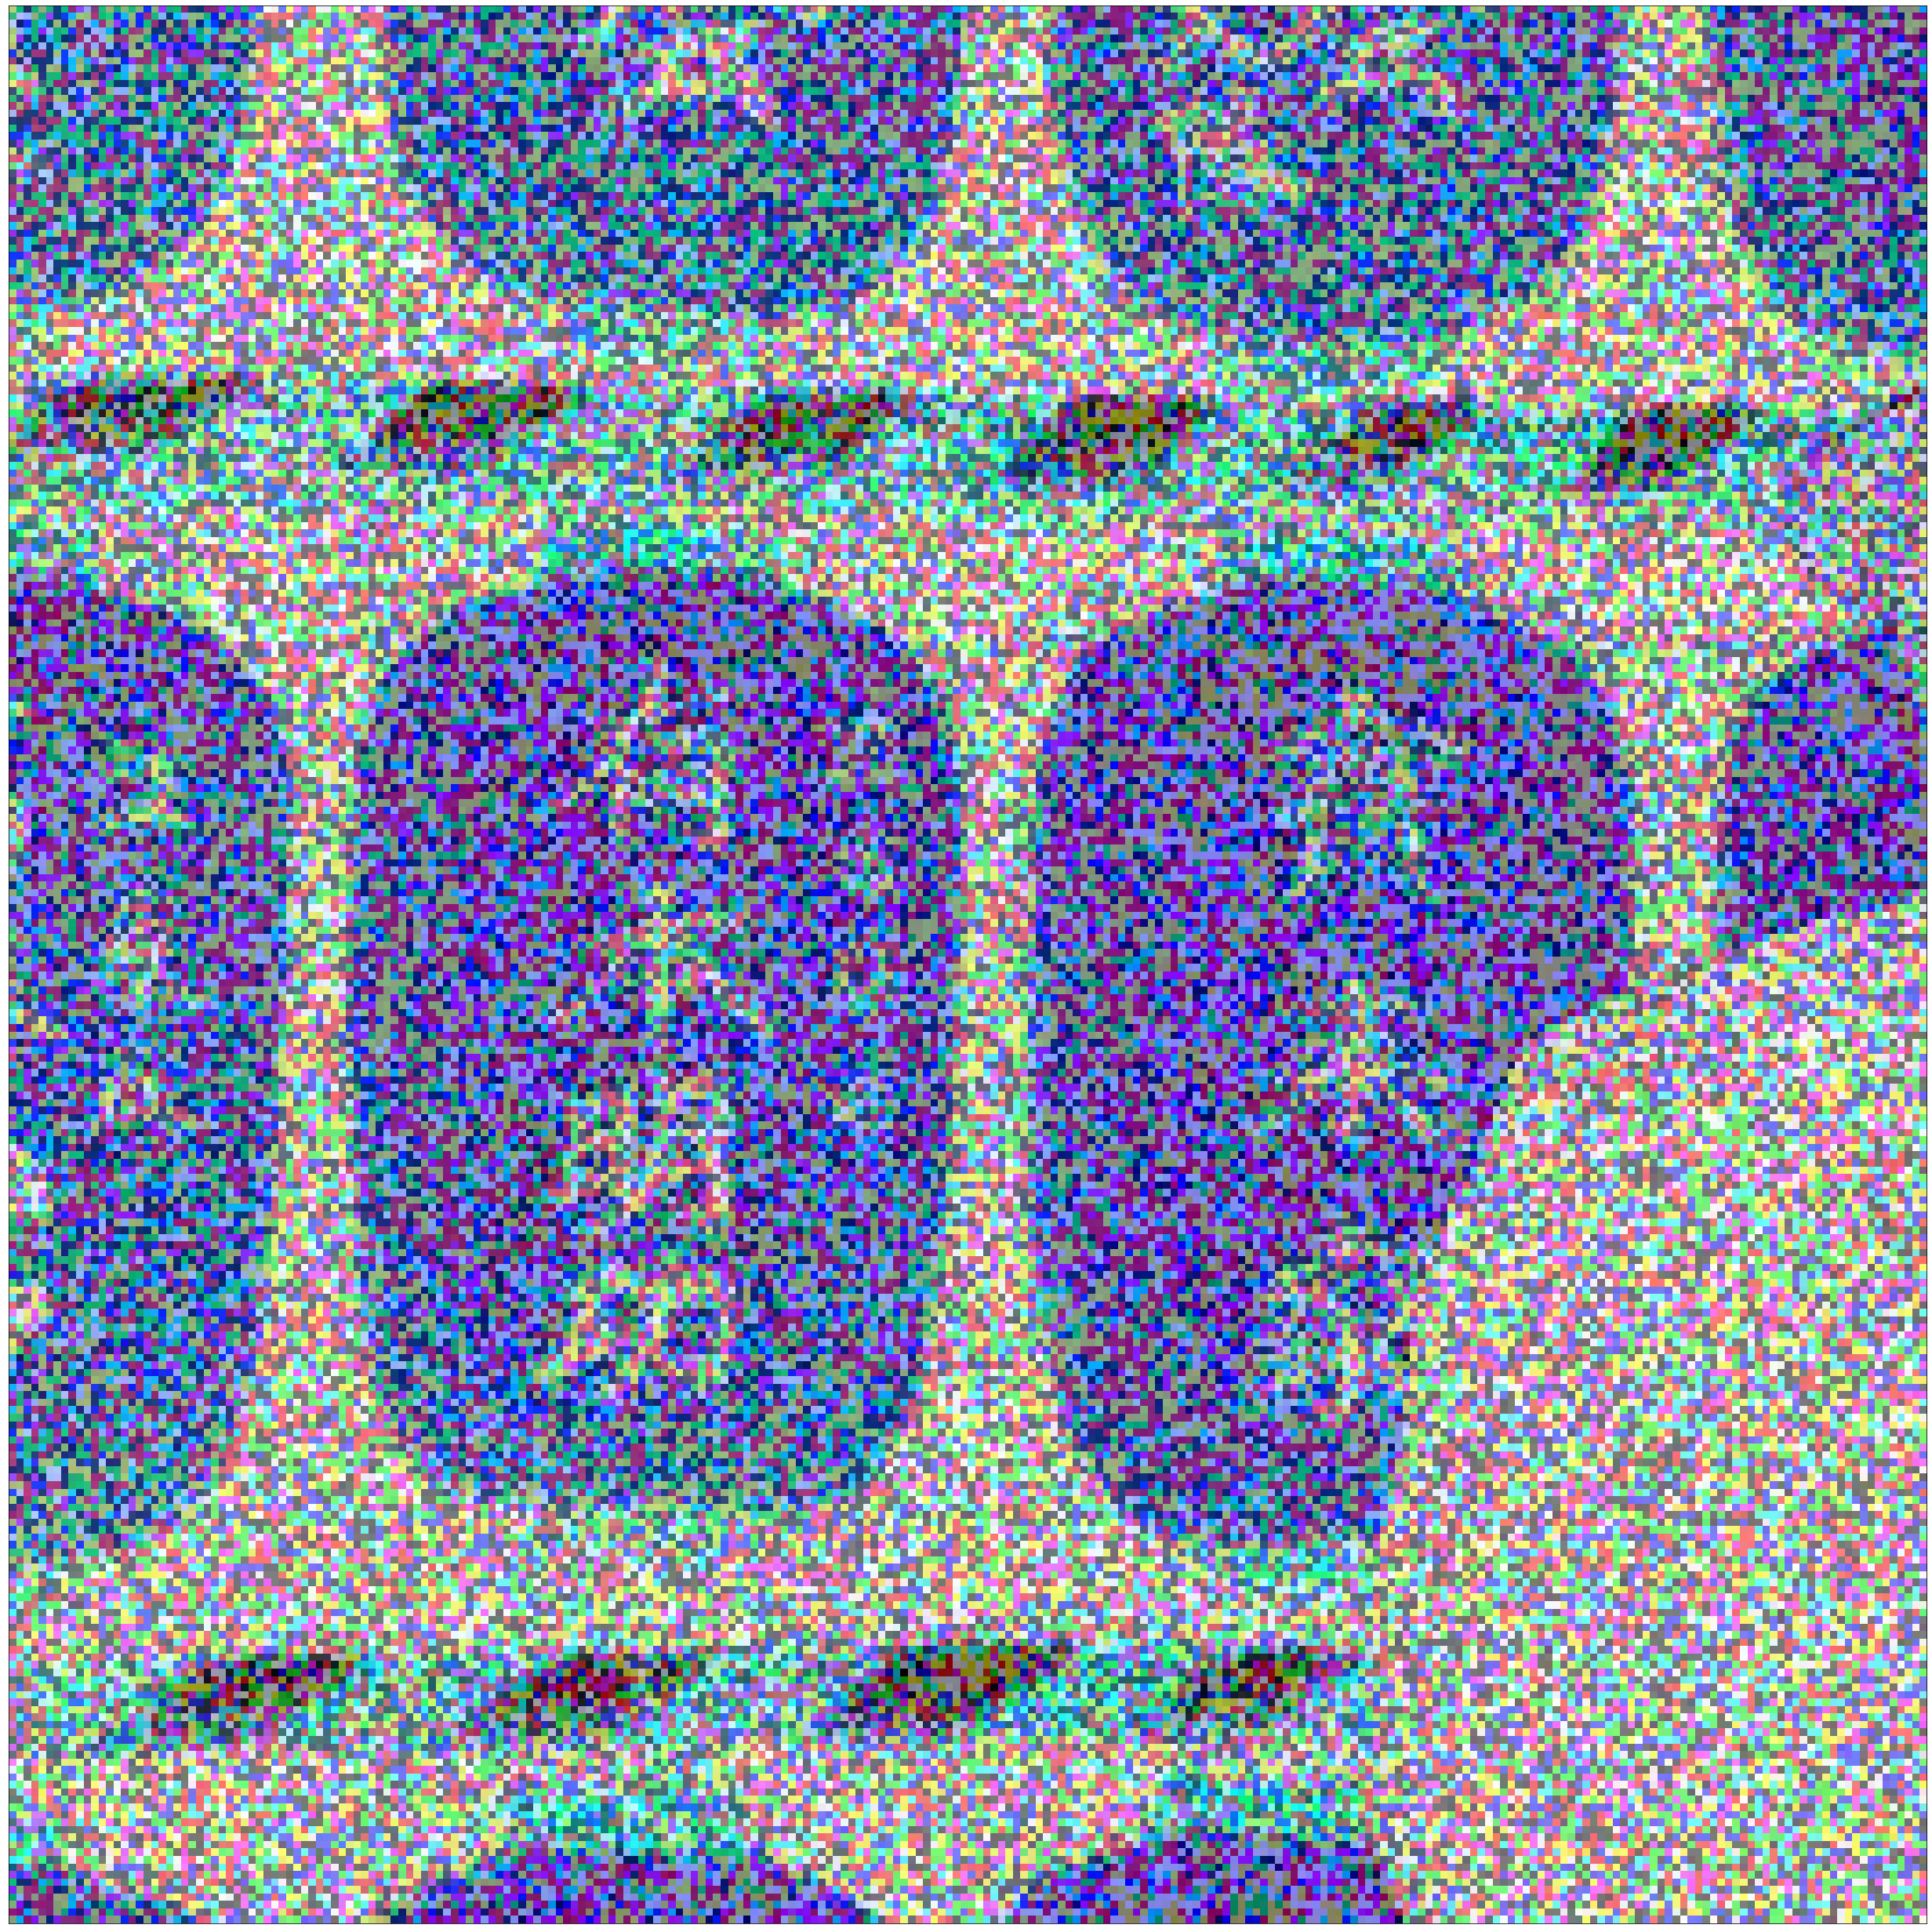

Epoch 0
(3, 256, 256, 3)
(3, 256, 256, 3)


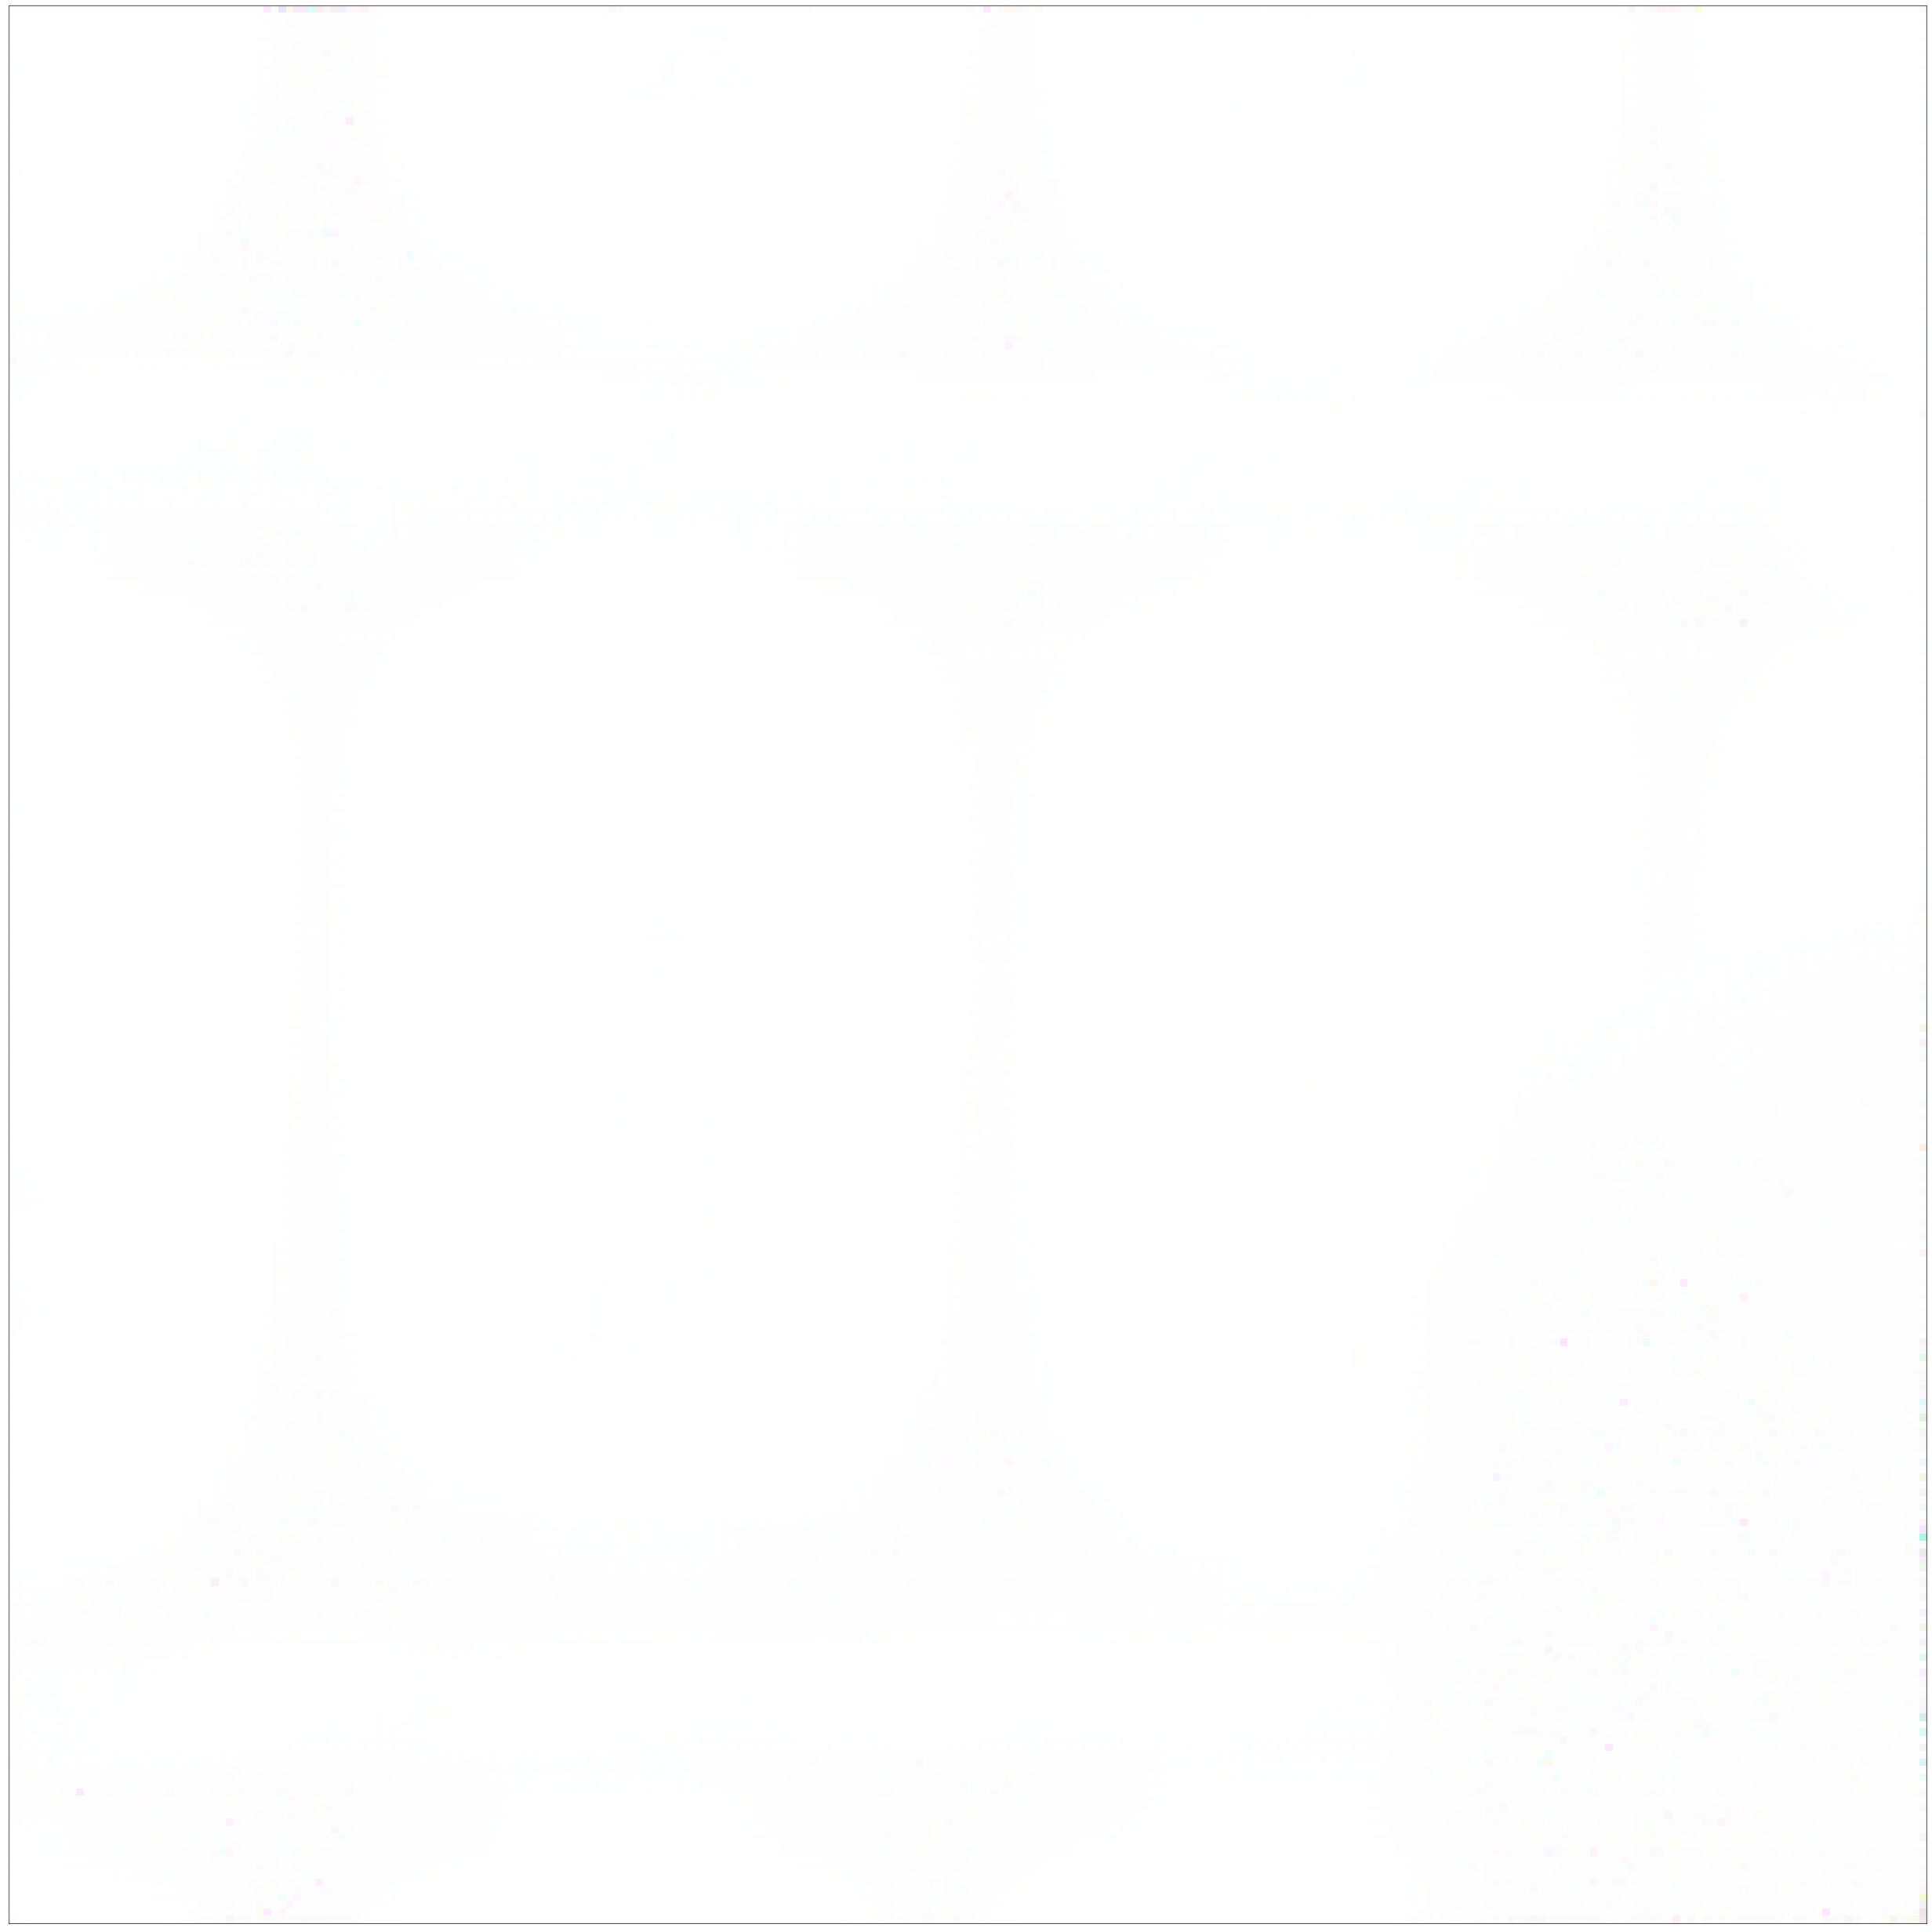

Epoch 1


KeyboardInterrupt: ignored

In [159]:
dataset = train_as_arr
print(dataset[0].shape)

# train model
train_3(d_model, g_model, gan_model, dataset,n_epochs=2, batch_size=1)

In [ ]:
import pandas
def plot_losses(history, lim):
  pandas.DataFrame(history).plot(figsize=(10,8))
  plt.grid(True)
  plt.gca().set_ylim(0,lim)
  plt.show()